# **Handling CT**
This notebook is inspired by these ct tutorials:
- Notebook by Guido Zuidhof : https://www.kaggle.com/gzuidhof/full-preprocessing-tutorial
- Notebook by Alexandr Moskalev : https://www.kaggle.com/allunia/pulmonary-dicom-preprocessing/comments

## Opening: What we will cover
- **Loading the DICOM files**
- **Converting the pixel values to Hounsfield Units (HU)**
- **CT windowing** : related with histogram modification
- **Resampling**

## Outline
- <a href='#CT_data'>**About Data**</a>
    - <a href='#CT_image_folder'>`About Image Folder`</a>
    - <a href='#CT_dicom'>`About DICOM file`</a>
- <a href='#CT_work_dicom'>**Working with dicom files**</a>
    - <a href='#CT_image'>`Image-wise steps`</a>
        - Step1: Control File Meta Information
        - Step2-1: Control dicom image
        - Step2-2: Transforming to Hounsfield Units
        - Step2-3: Image Windowing
    - <a href='#CT_slice'>`Slice-wise steps`</a>
        - Step1-1: Load CT-scans per patient
        - Step1-2: Visualize
        - Step2: Slices Windowing
    - <a href='#CT_voxel'>`Voxel-wise steps`</a>
        - Step1: The voxel size
        - Step2: Slice Thickness
        - Step3: Resampling the voxel size

<a id='CT_data'></a>
# **About Data**
In this tutorial, The data we are going to practice is `RSNA Pulmonary Embolism Detection` dataset

### RSNA Pulmonary Embolism Detection Challenge Terms of Use and Attribution

You may access and use these de-identified imaging datasets and annotations (“the data”) for non-commercial purposes only, including academic research and education, as long as you agree to abide by the following provisions:
1. Not to make any attempt to identify or contact any individual(s) who may be the subjects of the data.
2. If you share or re-distribute the data in any form, include a citation to the “RSNA-STR Pulmonary Embolism CT (RSPECT) Dataset, Copyright RSNA, 2020” and provide a link to this download site:

        https://www.rsna.org/education/ai-resources-and-training/ai-image-challenge/rsna-pe-detection-challenge-2020

<a id='CT_image_folder'></a>
## `About Image Folder`
- The location for each image is given by: `<StudyInstanceUID>/<SeriesInstanceUID>/<SOPInstanceUID>.dcm`  
  (* *Caution: Each dataset may have a different directory structure.*)
- Example
    - `<StudyInstanceUID>` : 0a4d7c9fa082
    - `<SeriesInstanceUID>` : 38eddda9207f
    - `<SOPInstanceUID>.dcm` : c7a7ad9160f5.dcm

In [10]:
from IPython.display import Image
import os
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import pydicom

In [11]:
## Call image file paths from folder

In [12]:
IMG_EXTENSION = ['.dcm', '.DCM']

In [13]:
def check_extension(filename):
    return any(filename.endswith(extension) for extension in ['.dcm', '.DCM'])

def load_scans_path(folder_path):
    """
    find 'IMG_EXTENSION' file paths in folder.
    return list
    
    """
    
    img_paths = []
    assert os.path.isdir(folder_path), '%s is not a valid directory'

    for root, _, fnames in sorted(os.walk(folder_path)):
        for fname in fnames:
            if check_extension(fname):
                path = os.path.join(root, fname)
                img_paths.append(path)
    return img_paths[:]

In [14]:
trainpath = "./input/rsna-str-pulmonary-embolism-detection/train"

train_img_paths = load_scans_path(trainpath)

In [15]:
train_img_paths

['./input/rsna-str-pulmonary-embolism-detection/train/0a4d7c9fa082/38eddda9207f/d12832a23a42.dcm',
 './input/rsna-str-pulmonary-embolism-detection/train/0a4d7c9fa082/38eddda9207f/c920a23b40c8.dcm',
 './input/rsna-str-pulmonary-embolism-detection/train/0a4d7c9fa082/38eddda9207f/c7a7ad9160f5.dcm',
 './input/rsna-str-pulmonary-embolism-detection/train/10d5afcc6c55/18798a4cdfd4/fffd639044cc.dcm',
 './input/rsna-str-pulmonary-embolism-detection/train/10d5afcc6c55/18798a4cdfd4/67d6288b2a7b.dcm',
 './input/rsna-str-pulmonary-embolism-detection/train/10d5afcc6c55/18798a4cdfd4/66e80f76f648.dcm',
 './input/rsna-str-pulmonary-embolism-detection/train/78a48d0c1337/0fa5fa6463e7/ff4814bbe324.dcm',
 './input/rsna-str-pulmonary-embolism-detection/train/78a48d0c1337/0fa5fa6463e7/aca3ebf018f1.dcm',
 './input/rsna-str-pulmonary-embolism-detection/train/78a48d0c1337/0fa5fa6463e7/bcc83b2ec5da.dcm']

<a id='CT_dicom'></a>
## `About DICOM file`
Open dicom file with `pydicom` package

In [16]:
example_path = train_img_paths[0] # select a img path form path list

In [17]:
example = pydicom.read_file(example_path, force=True) # reading even if no File Meta Information header is found

In [19]:
# DICOM Header
print(example)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 204
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.113654.2.70.1.255888651754624732269098324029827330740.1
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.826.0.1.3680043.8.498.1
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 1.2.2'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: "['ORIGINAL', 'PRIMARY', 'AXIAL']"
(0008, 0016) SOP Class UID                       UI: 80e30f500244
(0008, 0018) SOP Instance UID                    UI: d12832a23a42
(0008, 0060) Modality                            CS: 'CT'
(0018, 0050) Slice

___

<a id='CT_work_dicom'></a>
# **Working with dicom files**
Let's check CT step-by-step
- Image-wise steps
- Slice-wise steps
- Voxel-wise steps

<a id='CT_image'></a> 
## `Image-wise steps`

### Step1: Control File Meta Information

In [22]:
print("Slice Thickness: {}".format(example.SliceThickness)) #Instance
print("Rescale Intercept: {}".format(example[0x0028, 0x1052].value)) #hexadecimal
print("Rescale Slope: {}".format(example[0x0028, 0x1053].value)) #hexadecimal

Slice Thickness: 1.25
Rescale Intercept: -1024
Rescale Slope: 1


### Step2-1: Control dicom image

In [26]:
# Extract image(np.array) from DICOM 

In [27]:
ex_img = example.pixel_array

In [31]:
# image size, image datatype, pixel datatype
ex_img.shape, type(ex_img), ex_img.dtype

((512, 512), numpy.ndarray, dtype('uint16'))

In [32]:
# pixel value min max
np.min(ex_img), np.max(ex_img)

(0, 4000)

In [33]:
import matplotlib.pyplot as plt

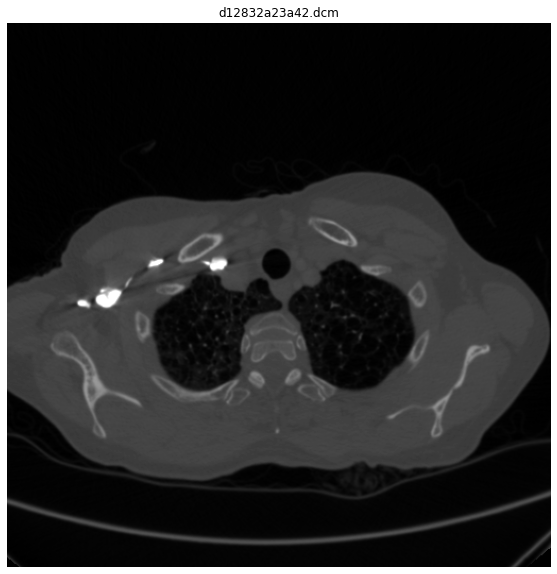

In [34]:
plt.figure(figsize=(10,10))
plt.imshow(ex_img, cmap='gray')
plt.axis("off")
plt.title(example_path.split('/')[-1])
plt.show()

### Step2-2: Transforming to Hounsfield Units

![HU](sample/HU.png)

reference: https://youtu.be/4pb1f79h7_I

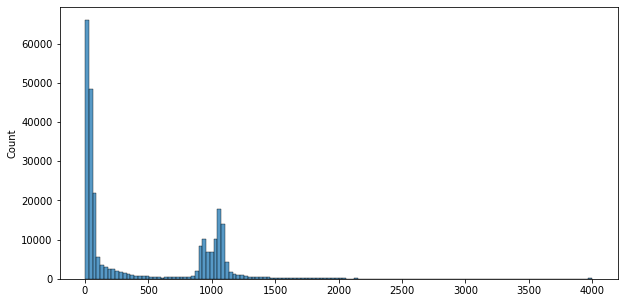

In [36]:
#Intensity histogram
plt.figure(figsize=(10,5))
sns.histplot(ex_img.flatten())
plt.show()

#### Rescale Intercept / Rescale Slope
:  CT images, whose pixel values are measured in Hounsfield units, which can have negative values, are "commonly" stored with an `unsigned integer`
$$
U = m*SV + b
$$

- $U$ : output units
- $m$ : rescale slope(0028|1053)
- $SV$ : stored value
- $b$ : rescale intercept(0028|1052)

reference: https://blog.kitware.com/dicom-rescale-intercept-rescale-slope-and-itk/

In [38]:
# Why? dicom.pixel_array -> usually uint / Pixel Padding Value Attribute(0028,0120)

In [45]:
def set_outside_scanner_to_air(hu_pixelarrays):
    """
    Pixel Padding Value Attribute(0028,0120) -> air
    """
    hu_pixelarrays[hu_pixelarrays < -1024] = -1024
    
    return hu_pixelarrays

In [46]:
def transform_to_hu(dicom_info, image):
    image = set_outside_scanner_to_air(image)
    
    intercept = dicom_info.RescaleIntercept
    slope = dicom_info.RescaleSlope
    hu_image = image.astype(np.float64) * slope + intercept
    hu_image = set_outside_scanner_to_air(hu_image.astype(np.int16))
    return hu_image

In [47]:
hu_ex_img = transform_to_hu(example, ex_img)

In [48]:
hu_ex_img.dtype

dtype('int16')

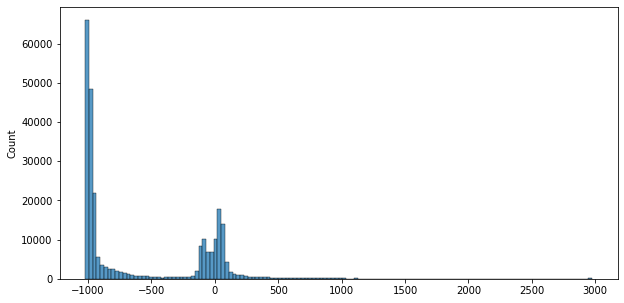

In [49]:
#Intensity histogram
plt.figure(figsize=(10,5))
sns.histplot(hu_ex_img.flatten())
plt.show()

### Step2-3: Image Windowing

![window](sample/window.jpg)

reference: http://www.sprawls.org/resources/DIGPROCESS/module.htm

In [50]:
class CT_Windowing:
    """
    CT image windowing : WL_Window Level, WW_Window Width
    mode(WL|WW) : 'abdomen'(60|400) , 'bone'(300|1500), 'brain'(40|80), 'chest'(40|400), 'lung'(-700|1500), 'custom'(WL|WW)
    custom_window : if mode == 'custom', set custom_window(WL, WW) -> list or tuple
    
    """
    def __init__(self, mode='custom', custom_window=None, norm=False):
        option = ['abdomen' , 'bone', 'brain', 'chest', 'lung', 'custom']
        assert mode in option, "Wrong mode: Enter \'abdomen\' , \'bone\', \'brain\', \'chest\', \'lung\', \'custom\'"
        
        self.mode = "window_" + mode
        if custom_window is not None:
            self.w_level = custom_window[0]
            self.w_width = custom_window[1]
            
        self.norm = norm
        
    def windowing(self):
        self.w_min = self.w_level - (self.w_width / 2)
        self.w_max = self.w_level + (self.w_width / 2)
        window_image = self.img.copy()
        window_image[window_image < self.w_min] = self.w_min
        window_image[window_image > self.w_max] = self.w_max
        
        if self.norm:
            window_image = np.uint8(((window_image - self.w_min) / (self.w_max - self.w_min)) * 255.0)
        return window_image
        
    def window_abdomen(self):
        self.w_level = 60
        self.w_width = 400
        
        return self.windowing()
        
    def window_bone(self):
        self.w_level = 300
        self.w_width = 1500
        
        return self.windowing()
    
    def window_brain(self):
        self.w_level = 40
        self.w_width = 80
        
        return self.windowing()
    
    def window_chest(self):
        self.w_level = 40
        self.w_width = 400
        
        return self.windowing()
        
    def window_lung(self):
        #SNUH version
        self.w_level = -700
        self.w_width = 1500
        #print('lung')
        return self.windowing()
        
    def window_custom(self):
        return self.windowing()
    
    
    def __call__(self, hu_img):
        self.img = hu_img
        self.opt = getattr(self, self.mode, lambda:'custom')
        return self.opt()  

In [51]:
window = CT_Windowing(mode='lung', norm=True)
lungw_img = window(hu_ex_img)

(-0.5, 511.5, 511.5, -0.5)

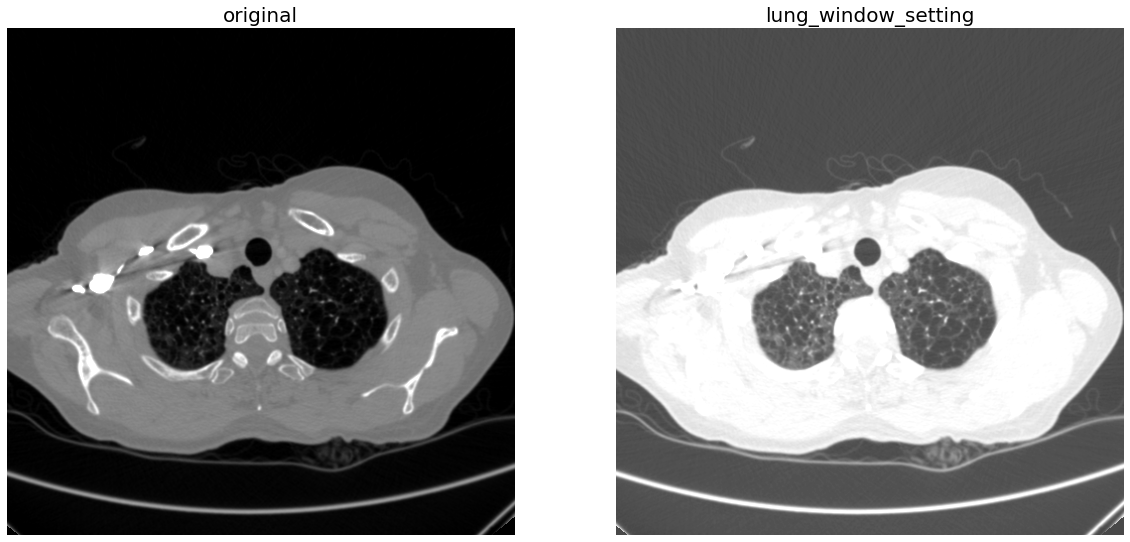

In [66]:
fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(hu_ex_img, vmin=-1000, vmax=1000,cmap="gray")
ax[0].set_title('original', fontsize=20)
ax[0].axis("off")
ax[1].imshow(lungw_img, vmin=0, vmax=255, cmap='gray')
ax[1].set_title('lung_window_setting', fontsize=20)
ax[1].axis("off")

<a id='CT_slice'></a> 
### `Slice-wise steps`

### Step1: Load CT-scans per patient

In [67]:
testpath = "./input/rsna-str-pulmonary-embolism-detection/test/0a5dc64cf7b8"

In [82]:
def load_ct_scans(patient_folder_path):
    """
    Function of Loading CT-scans "per patient"
    patient path to CT slices(HU)
    input: patient folder path -> list or tuple
    output: File Meta Information, CT sclices -> tuple
    """
    # call all image paths in directory
    dcm_paths = load_scans_path(patient_folder_path)
    
    slices = [pydicom.read_file(dcm_path, force=True) for dcm_path in dcm_paths]
    
    # **Sort the slices in ascending order
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    
    # stack slices
    images = np.stack([file.pixel_array for file in slices])
    images = images.astype(np.int16)
    
    # convert to HU
    intercept = slices[0].RescaleIntercept
    slope = slices[0].RescaleSlope
    hu_images = images.astype(np.float64) * slope + intercept
    hu_images = set_outside_scanner_to_air(hu_images.astype(np.int16))
    
    # return header of first dicom and stacked CT slices
    return slices[0], hu_images

In [83]:
_, test_imgs = load_ct_scans(testpath)

In [85]:
test_imgs.shape # (# of slices, row, col)

(220, 512, 512)

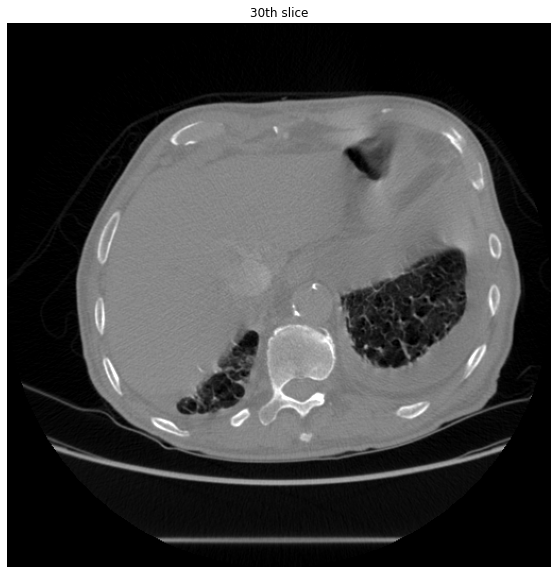

In [169]:
# show 30th slice
K_th = 30
plt.figure(figsize=(10,10))
plt.imshow(test_imgs[K_th-1], vmin= -1000, vmax=1000, cmap='gray')
plt.title('{}th slice'.format(K_th))
plt.axis("off")
plt.show()

### Step1-2: Visualize

In [ ]:
# wrong case

In [95]:
def w_sample_stack(stack, rows=6, cols=6, start_with=10, show_every=5):
    """
    plt.imshow 
    By default, a linear scaling mapping the lowest value to 0 
    and the highest to 1 is used. 
    
    """
    fig,ax = plt.subplots(rows,cols,figsize=[18,20])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title(f'slice {ind}')
        
        ax[int(i/rows),int(i % rows)].imshow(stack[ind],cmap='gray')
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()

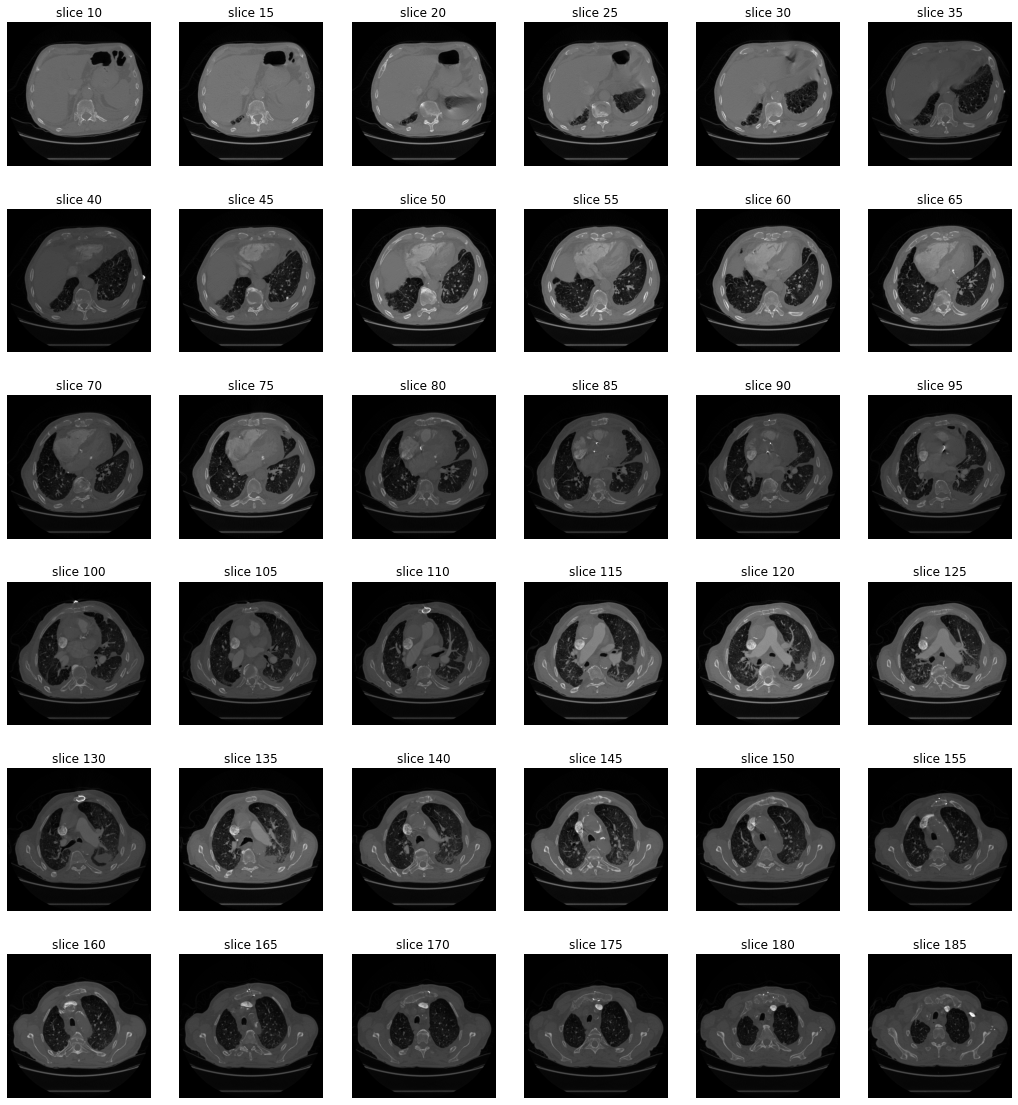

In [96]:
w_sample_stack(test_imgs)

In [ ]:
# solution

In [98]:
def sample_stack(stack, rows=6, cols=6, start_with=10, show_every=5, vmin=-1000, vmax=1000):
    fig,ax = plt.subplots(rows,cols,figsize=[18,20])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title(f'slice {ind}')
        ax[int(i/rows),int(i % rows)].imshow(stack[ind], vmin=vmin, vmax=vmax,cmap='gray')
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()

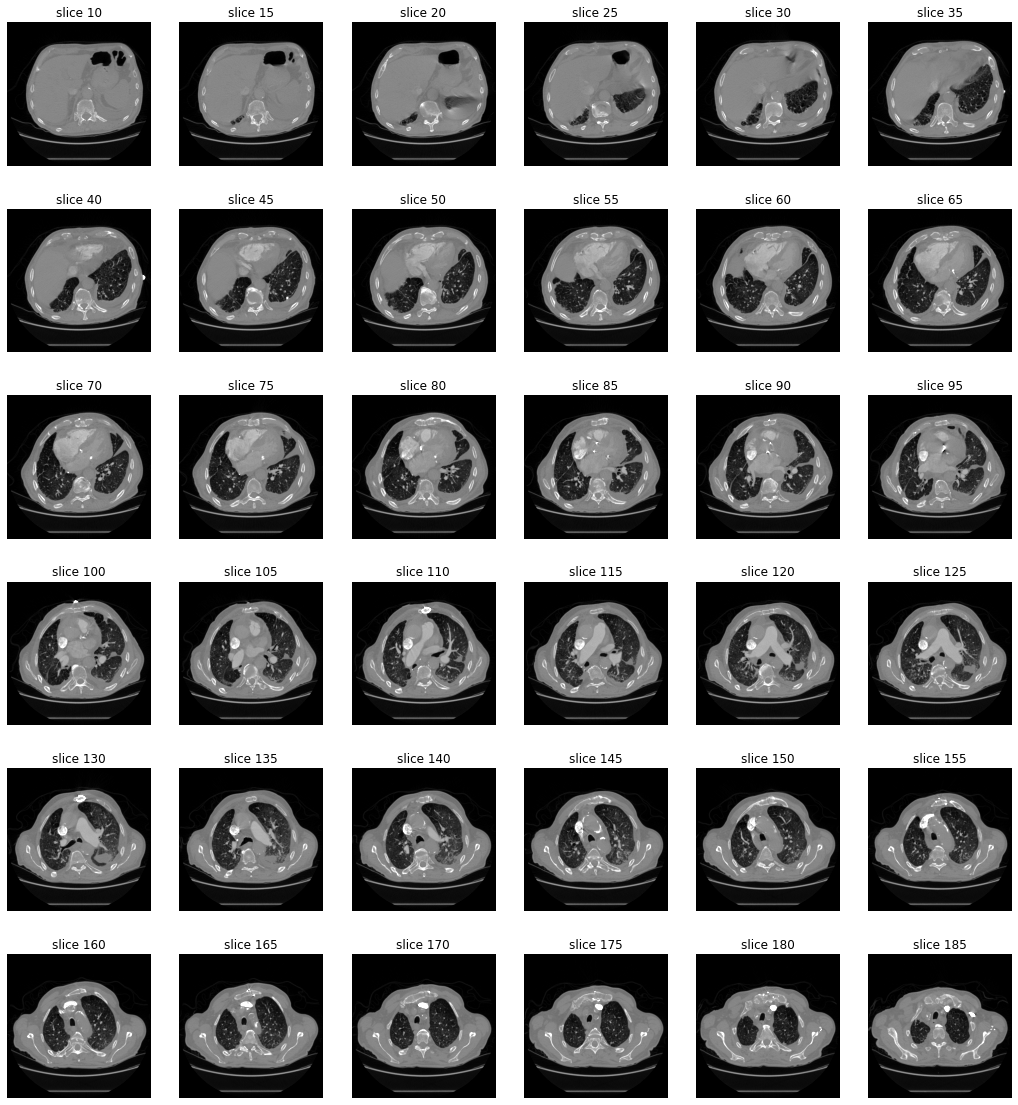

In [99]:
sample_stack(test_imgs)

### Step2: Slices Windowing

In [102]:
window = CT_Windowing(mode='lung', norm=True) # norm=True : [0,255]
lungw_imgs = window(test_imgs)

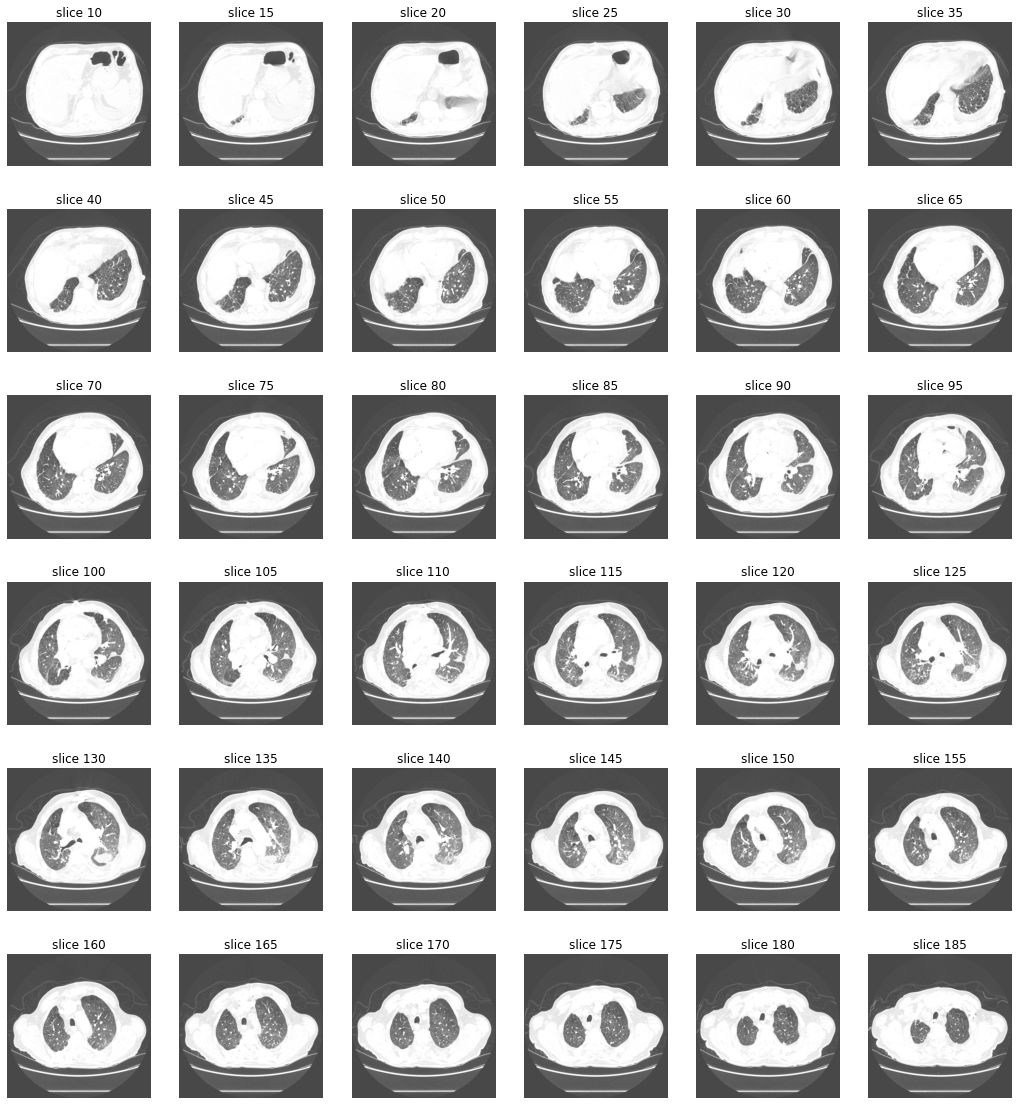

In [103]:
sample_stack(lungw_imgs, vmin=0, vmax=255)

<a id='CT_voxel'></a> 
### `Voxel-wise steps`

### Step1: Pixelspacing
- The pixelspacing attribute you can find in the dicom files is an important one. It tells us how much physical distance is covered by one pixel. You can see that there are only 2 values that describe the x- and y-direction in the plane of a transversal slice.
- For one patient this pixelspacing is usually the same for all slices.
- But between patients the pixelspacing can differ due to personal or institutional preferences of doctors and the clinic and it also depends on the scanner type. Consequently if you compare two images in the size of the lungs it does not automatically mean that the bigger one is really larger in the physical size of the organ!

![pixelspacing](sample/pixelspacing.png)

reference: https://simpleitk.readthedocs.io/en/v1.2.4/Documentation/docs/source/fundamentalConcepts.html

In [106]:
# N patients
N = 3

In [107]:
trainpath = "./input/rsna-str-pulmonary-embolism-detection/train"

train_img_paths = load_scans_path(trainpath)

In [108]:
# sample database
uid = [uid.split('.')[-2].split('/')[-3:] for uid in train_img_paths]
train_df_sample = pd.DataFrame(data=uid, columns=["StudyInstanceUID","SeriesInstanceUID","SOPInstanceUID"])
train_df_sample["folder_path"] = trainpath + "/" + train_df_sample.StudyInstanceUID + "/" + train_df_sample.SeriesInstanceUID

In [109]:
train_df_sample

StudyInstanceUID SeriesInstanceUID SOPInstanceUID  \
0     0a4d7c9fa082      38eddda9207f   d12832a23a42   
1     0a4d7c9fa082      38eddda9207f   c920a23b40c8   
2     0a4d7c9fa082      38eddda9207f   c7a7ad9160f5   
3     10d5afcc6c55      18798a4cdfd4   fffd639044cc   
4     10d5afcc6c55      18798a4cdfd4   67d6288b2a7b   
5     10d5afcc6c55      18798a4cdfd4   66e80f76f648   
6     78a48d0c1337      0fa5fa6463e7   ff4814bbe324   
7     78a48d0c1337      0fa5fa6463e7   aca3ebf018f1   
8     78a48d0c1337      0fa5fa6463e7   bcc83b2ec5da   

                                         folder_path  
0  ./input/rsna-str-pulmonary-embolism-detection/...  
1  ./input/rsna-str-pulmonary-embolism-detection/...  
2  ./input/rsna-str-pulmonary-embolism-detection/...  
3  ./input/rsna-str-pulmonary-embolism-detection/...  
4  ./input/rsna-str-pulmonary-embolism-detection/...  
5  ./input/rsna-str-pulmonary-embolism-detection/...  
6  ./input/rsna-str-pulmonary-embolism-detection/...  
7  ./input/rsna-str-pulmonary-embolism-detection/...  
8  ./input/rsna-str-pulmonary-embolism-detection/...

In [110]:
# sample function
def get_window_value(feature):
    if type(feature) == pydicom.multival.MultiValue:
        return np.int(feature[0])
    else:
        return np.int(feature)

pixelspacing_r = []
pixelspacing_c = []
slice_thicknesses = []
patient_id = []
patient_pth = []
row_values = []
column_values = []
window_widths = []
window_levels = []


patients = train_df_sample.SeriesInstanceUID.unique()[0:N]

for patient in patients:
    patient_id.append(patient)
    
    path = train_df_sample[train_df_sample.SeriesInstanceUID == patient].folder_path.values[0]
    example_dcm = os.listdir(path)[0]
    patient_pth.append(path)
    dataset = pydicom.dcmread(path + "/" + example_dcm)
    

    
    spacing = dataset.PixelSpacing
    slice_thicknesses.append(dataset.SliceThickness)
    
    row_values.append(dataset.Rows)
    column_values.append(dataset.Columns)
    pixelspacing_r.append(spacing[0])
    pixelspacing_c.append(spacing[1])
    
scan_properties = pd.DataFrame(data=patient_id, columns=["patient"])
scan_properties.loc[:, "rows"] = row_values
scan_properties.loc[:, "columns"] = column_values
scan_properties.loc[:, "area"] = scan_properties["rows"] * scan_properties["columns"]
scan_properties.loc[:, "pixelspacing_r"] = pixelspacing_r
scan_properties.loc[:, "pixelspacing_c"] = pixelspacing_c
scan_properties.loc[:, "pixelspacing_area"] = scan_properties.pixelspacing_r * scan_properties.pixelspacing_c
scan_properties.loc[:, "slice_thickness"] = slice_thicknesses
scan_properties.loc[:, "patient_pth"] = patient_pth

scan_properties.head()

patient  rows  columns    area  pixelspacing_r  pixelspacing_c  \
0  38eddda9207f   512      512  262144        0.632812        0.632812   
1  18798a4cdfd4   512      512  262144        0.519531        0.519531   
2  0fa5fa6463e7   512      512  262144        0.707031        0.707031   

   pixelspacing_area  slice_thickness  \
0           0.400452             1.25   
1           0.269913             1.25   
2           0.499893             1.25   

                                         patient_pth  
0  ./input/rsna-str-pulmonary-embolism-detection/...  
1  ./input/rsna-str-pulmonary-embolism-detection/...  
2  ./input/rsna-str-pulmonary-embolism-detection/...

In [ ]:
# real data distribution

In [131]:
dicom_headers = pd.read_csv("./input/rsna-str-pulmonary-embolism-detection/rsna-pulmonary-embolism-dicom-header-data.csv")

In [132]:
dicom_headers.pixelspacing_r

0       0.871094
1       0.683594
2       0.618000
3       0.683594
4       0.691406
          ...   
7274    0.671875
7275    0.666016
7276    0.648438
7277    0.741000
7278    0.781250
Name: pixelspacing_r, Length: 7279, dtype: float64

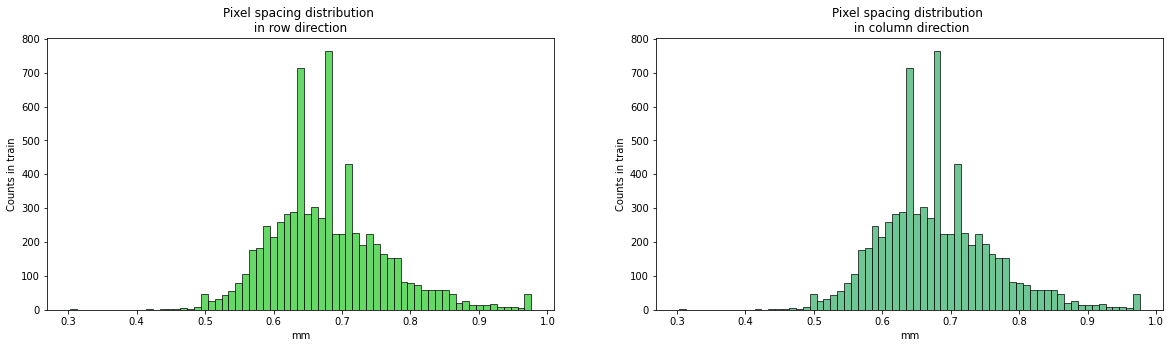

In [135]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.histplot(dicom_headers.pixelspacing_r.values, ax=ax[0], color="Limegreen", kde=False)
ax[0].set_title("Pixel spacing distribution \n in row direction ")
ax[0].set_ylabel("Counts in train")
ax[0].set_xlabel("mm")
sns.histplot(dicom_headers.pixelspacing_c.values, ax=ax[1], color="Mediumseagreen", kde=False)
ax[1].set_title("Pixel spacing distribution \n in column direction");
ax[1].set_ylabel("Counts in train");
ax[1].set_xlabel("mm");

### Step2: Slice thickness

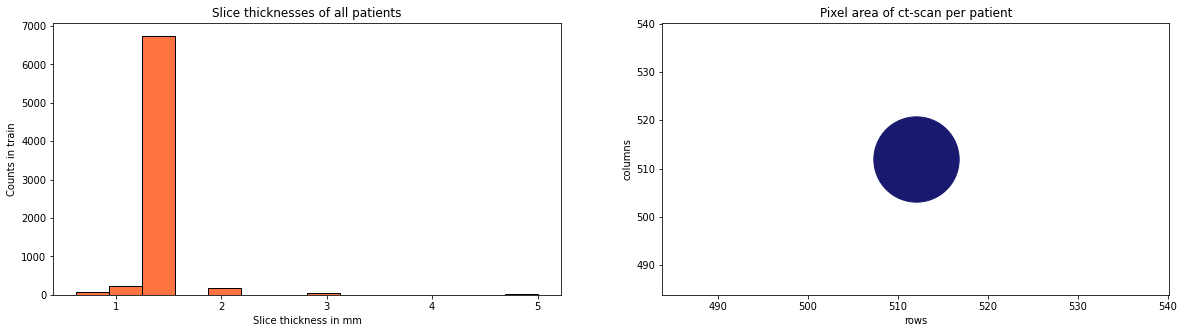

In [140]:
counts = dicom_headers.groupby(["rows", "columns"]).size()
counts = counts.unstack()
counts.fillna(0, inplace=True)


fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.histplot(dicom_headers.slice_thickness.values, color="orangered", kde=False, ax=ax[0])
ax[0].set_title("Slice thicknesses of all patients");
ax[0].set_xlabel("Slice thickness in mm")
ax[0].set_ylabel("Counts in train");

for n in counts.index.values:
    for m in counts.columns.values:
        ax[1].scatter(n, m, s=counts.loc[n,m], c="midnightblue")
ax[1].set_xlabel("rows")
ax[1].set_ylabel("columns")
ax[1].set_title("Pixel area of ct-scan per patient");

In [112]:
thick_type_path1 = "./input/rsna-str-pulmonary-embolism-detection/train/0a4d7c9fa082"

In [113]:
ttpdatainfo1, ttp_imgs1 = load_ct_scans(thick_type_path1)

In [114]:
ttpdatainfo1.SliceThickness

"1.25"

In [145]:
thick_type_path2 = "./input/rsna-str-pulmonary-embolism-detection/test/62dfc5f411e8"

In [146]:
ttpdatainfo2, ttp_imgs2 = load_ct_scans(thick_type_path2)

In [147]:
ttpdatainfo2.SliceThickness

"2.0"

'71fc236fad2a'

(-0.5, 511.5, 511.5, -0.5)

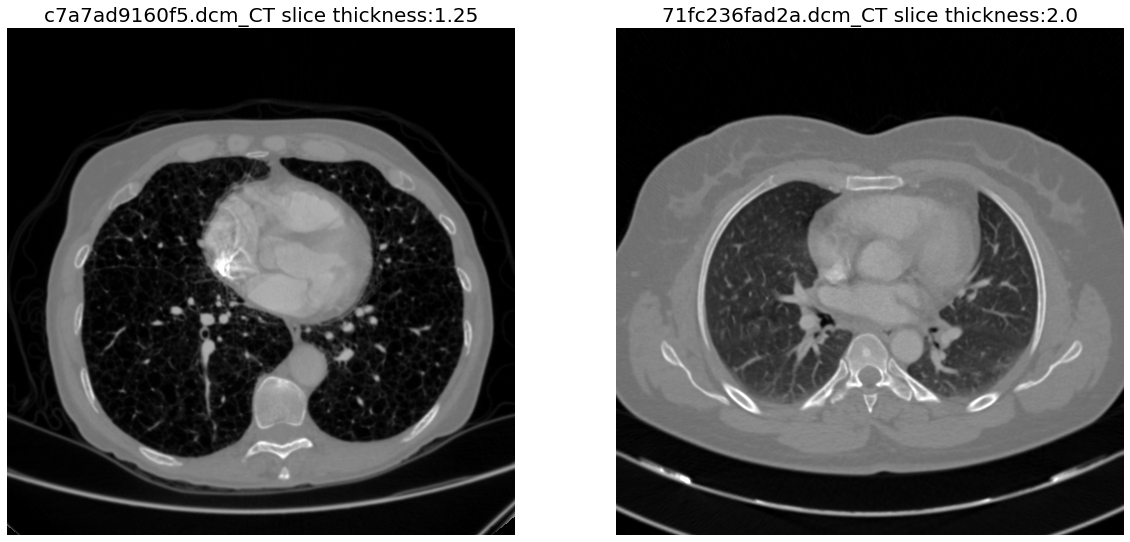

In [164]:
fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(ttp_imgs1[0], vmin=-1000, vmax=1000, cmap="gray")
ax[0].set_title('{}.dcm_CT slice thickness:{}'.format(ttpdatainfo1[0x0008,0x0018].value, \
                                               ttpdatainfo1.SliceThickness), fontsize=20)
ax[0].axis("off")
ax[1].imshow(ttp_imgs2[0], vmin=-1000, vmax=1000, cmap='gray')
ax[1].set_title('{}.dcm_CT slice thickness:{}'.format(ttpdatainfo2[0x0008,0x0018].value, \
                                               ttpdatainfo2.SliceThickness), fontsize=20)
ax[1].axis("off")

### Step3: Resampling the voxel size

In [149]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([scan.SliceThickness] + list(scan.PixelSpacing), dtype=np.float32)
    
    resize_factor = spacing / new_spacing
    new_shape = np.round(image.shape * resize_factor)
    
    # recompute the resize factor and spacing such that we match the rounded new shape above
    rounded_resize_factor = new_shape / image.shape
    rounded_new_spacing = spacing / rounded_resize_factor
    
    # zoom with resize factor
    image = scipy.ndimage.interpolation.zoom(image, rounded_resize_factor, mode='nearest')
    
    return image, rounded_new_spacing

In [150]:
img_resampled, spacing = resample(ttp_imgs2, ttpdatainfo2, [1,1,1])
print("Shape before resampling\t", ttp_imgs2.shape)
print("Shape after resampling\t", img_resampled.shape)

Shape before resampling	 (1, 512, 512)
Shape after resampling	 (2, 347, 347)


Text(0.5, 1.0, 'Resampled: voxel_size [1,1,1]')

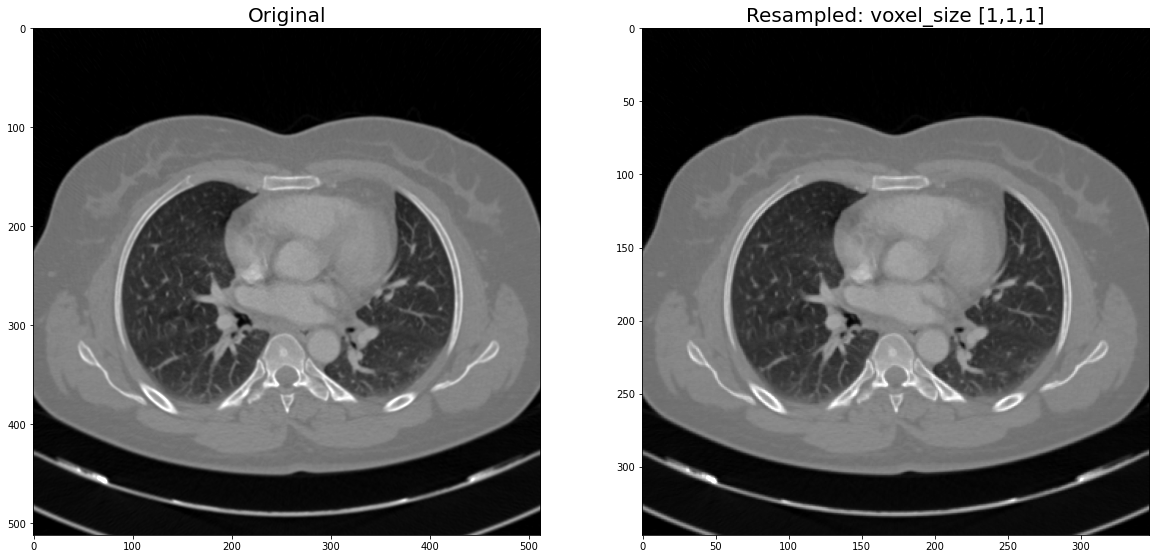

In [151]:
fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(ttp_imgs2[0], vmin=-1000, vmax=1000, cmap="gray")
ax[0].set_title('Original', fontsize=20)
ax[1].imshow(img_resampled[0], vmin=-1000, vmax=1000, cmap='gray')
ax[1].set_title('Resampled: voxel_size [1,1,1]', fontsize=20)

___